<a href="https://colab.research.google.com/github/hoki9/Healthtech_neuro/blob/master/Case_1_Heart_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Case 1 - Heart Disease Classification
------------------------------------
Henrik Hokkanen, Simo Mäkelä  
23.1.2020  
Neural Networks for Health Technology Applications  
Helsinki Metropolia University of Applied Sciences

In this exercise, the aim is to create and train a dense neural network to predict the presence of heart disease using the dataset at https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from scipy.signal import savgol_filter

__TODO__ Introduction of the data set, what data it contains, characteristics (size, attributes, missing values, descriptive statistics etc.)

In [0]:
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
col_names = ['age','sex','cp','trestbps','chol','fbs','restecg','thalac','exang','oldpeak','slope','ca','thal','num']
df = pd.read_csv(url, 
                 sep = ',', 
                 header = None, 
                 index_col = None,
                 names = col_names,
                 na_values = '?')
df.dropna()
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


scale or normalize the variables  
replace missing values with zeros, means/medians or random values

In [0]:
#normalized_df = (df - df.mean()) / df.std()
scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = col_names
scaled_df = scaled_df.fillna(0)
scaled_df['num'] = (df.filter(['num']) > 0) * 1.0
#scaled_df['num'][scaled_df['num'] == 1].dropna().count() # 164 zeros, 139 ones
scaled_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,-0.120081,-0.320132,0.158416,0.084488,0.088954,0.148515,-0.004950,-0.104392,0.326733,0.149752,-0.399340,0.663366,0.430693,0.458746
std,0.695282,0.467299,0.960126,0.879987,0.809014,0.356198,0.497486,0.703846,0.469794,0.725672,0.616226,0.934375,0.484596,0.499120
min,-2.076923,-1.000000,-2.000000,-1.800000,-1.796875,0.000000,-0.500000,-2.523077,0.000000,-0.500000,-1.000000,0.000000,0.000000,0.000000
25%,-0.615385,-1.000000,0.000000,-0.500000,-0.468750,0.000000,-0.500000,-0.600000,0.000000,-0.500000,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.384615,0.000000,1.000000,0.500000,0.531250,0.000000,0.500000,0.400000,1.000000,0.500000,0.000000,1.000000,1.000000,1.000000
max,1.615385,0.000000,1.000000,3.500000,5.046875,1.000000,0.500000,1.507692,1.000000,3.375000,1.000000,3.000000,1.000000,1.000000


separate the data/input and labels/output

In [0]:
train_data, test_data = train_test_split(scaled_df, test_size=0.2, shuffle=False)
train_data.corr()['num']

age         0.251275
sex         0.275722
cp          0.455058
trestbps    0.159502
chol        0.112902
fbs        -0.008312
restecg     0.206846
thalac     -0.450983
exang       0.443474
oldpeak     0.418219
slope       0.364258
ca          0.449891
thal        0.534191
num         1.000000
Name: num, dtype: float64

feature selection

In [0]:
#selected_features = ['age','sex','cp','trestbps','chol','fbs','restecg','thalac','exang','oldpeak','slope','ca','thal']
selected_features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalac', 'oldpeak']
#selected_features = ['age', 'sex', 'trestbps', 'chol', 'thalac', 'oldpeak']
# input
train_X = train_data.filter(selected_features)
test_X = test_data.filter(selected_features)
# output
train_y = train_data.filter(['num'])
test_y = test_data.filter(['num'])

__TODO__ Description of models, training and testing (epochs, batch sizes, solver settings), data arrangement (training/testing/validation)

Try different neural network architectures (number of layers, number of neurons within layer), batch sizes and number of epochs, and solver settings and compare them with each other.

Try to find the simplest, fastest and smallest possible model and settings that solves the problem most accurately.

In [0]:
#reg_L2 = tf.keras.regularizers.l2(0.01)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(9, activation='sigmoid', input_shape=(train_X.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#opt = tf.keras.optimizers.SGD(lr=0.05)# lr 0.025 # decay=0.00005, 
opt = tf.keras.optimizers.RMSprop(lr=0.025) # lr 0.025
#opt = tf.keras.optimizers.Adam(lr=0.001)# lr 0.018 # decay=0.00005, 

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 9)                 72        
_________________________________________________________________
dropout_16 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_121 (Dense)            (None, 4)                 40        
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(np.asarray(train_X), np.asarray(train_y), verbose=0, batch_size=90, validation_split=0.25, epochs=300)

#model.evaluate(np.asarray(test_data), np.asarray(test_labels), verbose=2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


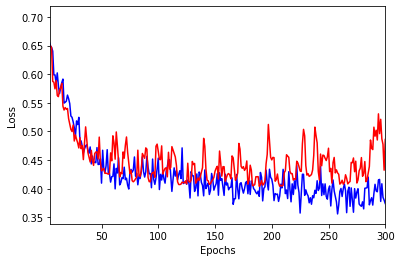

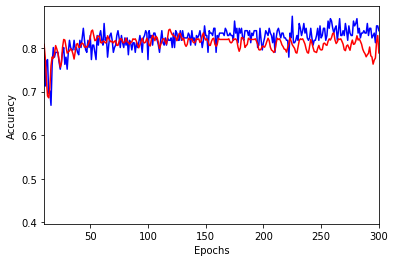

In [0]:
# Plot the training + validation loss and mean absolute error

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

time = range(1,len(loss)+1)

plt.plot(time, loss, 'b-')
plt.plot(time, val_loss, 'r-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim((5,300))
plt.show()

plt.plot(time, acc, 'b-')
plt.plot(time, savgol_filter(val_acc, 5, 3), 'r-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim((10,300))
plt.show()

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(9, activation='sigmoid', input_shape=(train_X.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#opt = tf.keras.optimizers.SGD(lr=0.05)# lr 0.025 # decay=0.00005, 
opt = tf.keras.optimizers.RMSprop(lr=0.025) # lr 0.025
#opt = tf.keras.optimizers.Adam(lr=0.001)# lr 0.018 # decay=0.00005, 

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
# Train model with early stopping based on learning curve, to avoid overfitting.
# Use all data: no validation set.
model.fit(np.asarray(train_X), np.asarray(train_y), verbose=0, batch_size=90, epochs=170)

In [0]:
model.evaluate(np.asarray(test_X), np.asarray(test_y))

61/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6400451103194815, 0.7704918]

__TODO__ Results, both graphically and textually 

__TODO__ Conclusions (observations, achieving objectives)